### Load Data, drop empty Txt and Settings
----

In [202]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import csv

In [203]:
## SETTINGS

# word embeddings
SET_vectorizer_hash = False
SET_vectorizer_tfidf = True
SET_vectorizer_glove = False
SET_vectorizer_OHE = False

# active models
SET_NN_active = False


SET_datapath = "data_pp_sample2.json"

df = pd.read_json(SET_datapath, orient="columns")

df.drop(df[df.comment_text.str.len() == 0].index, inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,comment_text,toxic,sentence_lengths
0,officious busybody editing nazi january 7th 20...,0,55
1,baneesh baburaj working data supporting team s...,1,78
2,dunmanway title change rockpocket appears impo...,0,26
3,cleanup known croatian juraj julije croat work...,0,96
4,hey real end plain,1,4


### Word Embedding

----

#### Hash Vectorizer

In [204]:
if SET_vectorizer_hash:

    vectorizer_hash = HashingVectorizer(ngram_range=(1,2), n_features=500)
    X = vectorizer_hash.fit_transform(df["comment_text"].values.tolist()).toarray()
    y = df["toxic"].values

#### TFidf Vectorizer

In [205]:
if SET_vectorizer_tfidf:

    vectorizer_tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=500)
    X = vectorizer_tfidf.fit_transform(df["comment_text"].values.tolist()).toarray()
    y = df['toxic'].values

#### Glove Vectorizer

In [206]:
import numpy as np
np.seterr(invalid='ignore')

def get_embedding(series, model, tokenizer):
    embedding_matrix = []

    for text in series.to_list():
        text_vec = np.zeros(model.vector_size)
        number_of_vectors = 0

        tokens = tokenizer.tokenize(text)

        for token in tokens:
            number_of_vectors += 1

            if token in glove_model.key_to_index:
                text_vec = text_vec + model[token]

        embedding_matrix.append( text_vec / number_of_vectors)

    return np.array(embedding_matrix)

In [207]:
if SET_vectorizer_glove:
    import gensim.downloader as api

    glove_model = api.load("glove-wiki-gigaword-300")

In [208]:
if SET_vectorizer_glove:
    from nltk.tokenize import RegexpTokenizer
    tokenizer = RegexpTokenizer(r"[a-zA-Z0-9]+")

    X = get_embedding(df.comment_text, glove_model, tokenizer)
    y = df.toxic.values

#### OneHotEncoder

In [209]:
if SET_vectorizer_OHE:

    from sklearn.preprocessing import OneHotEncoder
    encoder = OneHotEncoder()
    model_ohe = encoder.fit_transform(df[["comment_text"]]).toarray()

### Split Data for Models
----

In [210]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [211]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (23978, 500)
X_test shape: (5995, 500)
y_train shape: (23978,)
y_test shape: (5995,)


### Train Models and get Scores

----

#### Try... Neural Network

In [212]:
if SET_NN_active:

    import numpy as np
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation, Flatten


    # convert labels to categorical data
    num_classes = 2
    input_shape = X_train.shape


    # define the model architecture
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.15))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['precission'])

    model.fit(X_train, y_train, batch_size=1, epochs=5, validation_data=(X_test, y_test))

In [213]:
def model_train(model, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    y_pred_tr = model.predict(X_train)
    y_pred = model.predict(X_test)

    report = classification_report(y_test,y_pred, output_dict=True)
    # print(report)
    recall = report["macro avg"]["recall"]
    precision = report["macro avg"]["precision"]


    print("--------------------Training Performance---------------------")
    print(accuracy_score(y_train,y_pred_tr))
    print(classification_report(y_train,y_pred_tr))
    print("-------------------------------------------------------------")
    print("--------------------Testing Performance----------------------")
    print(accuracy_score(y_test,y_pred))
    print(classification_report(y_test,y_pred))

    sns.heatmap(confusion_matrix(y_test, y_pred),cmap='viridis',annot=True,fmt='.4g')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()

    # Save recall value in a CSV file
    with open("performance.csv", mode='a') as csv_file:
        fieldnames = ['Model', 'WordEmbedding', 'Precision', 'Recall']
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

        # adds header in case csv is empty
        if csv_file.tell() == 0:
            writer.writeheader()

        writer.writerow({'Model': model.__class__.__name__, 'WordEmbedding': 'TFidf', 'Precision': precision, 'Recall': recall})

#### Naive Bayes:

--------------------Training Performance---------------------
0.7046459254316457
              precision    recall  f1-score   support

           0       0.69      0.98      0.81     15564
           1       0.84      0.19      0.32      8414

    accuracy                           0.70     23978
   macro avg       0.77      0.59      0.56     23978
weighted avg       0.75      0.70      0.64     23978

-------------------------------------------------------------
--------------------Testing Performance----------------------
0.7124270225187657
              precision    recall  f1-score   support

           0       0.70      0.98      0.82      3927
           1       0.84      0.21      0.33      2068

    accuracy                           0.71      5995
   macro avg       0.77      0.59      0.57      5995
weighted avg       0.75      0.71      0.65      5995



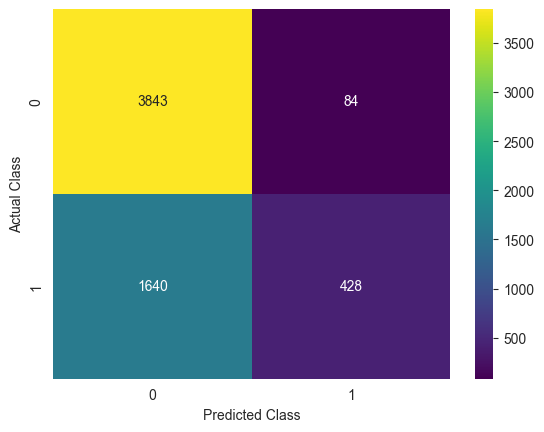

In [214]:
modelNB = MultinomialNB()
model_train(modelNB, X_train, X_test, y_train, y_test)

#### Logistic Regression (Best Model) :

--------------------Training Performance---------------------
0.7052714988739678
              precision    recall  f1-score   support

           0       0.70      0.97      0.81     15564
           1       0.79      0.22      0.34      8414

    accuracy                           0.71     23978
   macro avg       0.74      0.59      0.58     23978
weighted avg       0.73      0.71      0.65     23978

-------------------------------------------------------------
--------------------Testing Performance----------------------
0.7084236864053378
              precision    recall  f1-score   support

           0       0.70      0.96      0.81      3927
           1       0.75      0.23      0.35      2068

    accuracy                           0.71      5995
   macro avg       0.73      0.60      0.58      5995
weighted avg       0.72      0.71      0.65      5995



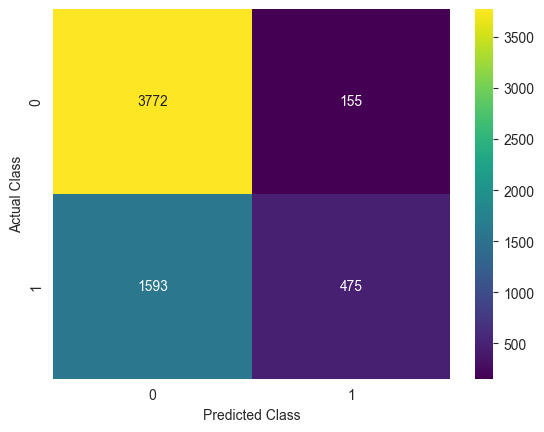

In [215]:
modelLR = LogisticRegression(max_iter=1000)
model_train(modelLR, X_train, X_test, y_train, y_test)

#### Random forest:

--------------------Training Performance---------------------
0.7016431729084994
              precision    recall  f1-score   support

           0       0.69      1.00      0.81     15564
           1       0.97      0.15      0.27      8414

    accuracy                           0.70     23978
   macro avg       0.83      0.58      0.54     23978
weighted avg       0.79      0.70      0.62     23978

-------------------------------------------------------------
--------------------Testing Performance----------------------
0.6992493744787323
              precision    recall  f1-score   support

           0       0.69      0.99      0.81      3927
           1       0.90      0.14      0.25      2068

    accuracy                           0.70      5995
   macro avg       0.79      0.57      0.53      5995
weighted avg       0.76      0.70      0.62      5995



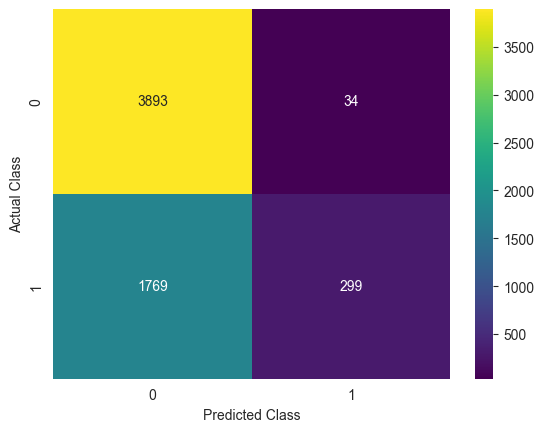

In [216]:
model = RandomForestClassifier(n_estimators=50,max_depth=15,max_features='sqrt')
model_train(model, X_train, X_test, y_train, y_test)

In [217]:
print("finished")

finished
